In [1]:
'''this code will compare the results from LOGCUBE to a run of pPXF I do myself'''

'this code will compare the results from LOGCUBE to a run of pPXF I do myself'

In [1]:
import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits


from astropy.cosmology import WMAP9 as cosmo

import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches

import sys 

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()




In [2]:
file='../MaNGA_code/practice_logcube/manga-8459-3702-LOGCUBE.fits'
file='../MaNGA_code/practice_logcube/manga-8459-3702-LOGCUBE-SPX-GAU-MILESHC.fits'

In [3]:
logcube=pyfits.open(file)
#print(logcube[0].header)
print('DAP VERSION', logcube[0].header['VERSDAP'])

print('REFF', logcube[0].header['REFF'])
#print('Binning?', logcube[0].header['BINTYPE'])
print('SN min in fit', logcube[0].header['SCMINSN'])
print('Input Vel', logcube[0].header['SCINPVEL'])
print('Input Sigma', logcube[0].header['SCINPSIG'])
print('Number of Stellar Templates', logcube[0].header['NSCMOD'])
print('Type of Fitting', logcube[0].header['SCTYPE'])
print('PpXF? ', logcube[0].header['SCMETH'])
print('Template lib', logcube[0].header['PPXFTPLK'])
print('Bias value', logcube[0].header['PPXFBIAS'])
print('Cleaned?', logcube[0].header['PPXFCLN'])
print('Moments', logcube[0].header['PPXFMOM'])
print('Polynomial Degree', logcube[0].header['PPXFDEG'])
print('Multiplicative Polynomial Degree', logcube[0].header['PPXFMDEG'])



DAP VERSION 2.0.2
REFF 4.0408902
SN min in fit 1.0
Input Vel 21648.163
Input Sigma 100.0
Number of Stellar Templates 798
Type of Fitting stellar_kinematics
PpXF?  ppxf
Template lib MILESHC
Bias value None
Cleaned? False
Moments 2
Polynomial Degree 8
Multiplicative Polynomial Degree -1


In [4]:
print(shape(logcube[6].data))

(4563, 42, 42)


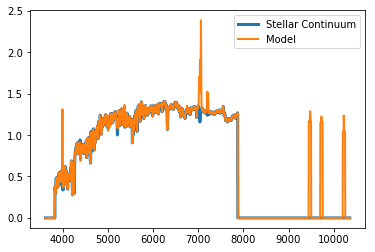

In [5]:
stellar_cont=logcube[6].data-logcube[7].data-logcube[8].data
plt.plot(logcube[4].data,stellar_cont[:,20,20],lw=3, label='Stellar Continuum')
plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=2, label='Model')
plt.legend()
#plt.xlim([5400,5600])
plt.show()

In [8]:
xs=logcube[4].data
ys=logcube[1].data[:,20,20]
noise=logcube[2].data[:,20,20]
mask=logcube[3].data[:,20,20]

print(shape(mask))


(4563,)


In [9]:

import sys 

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()

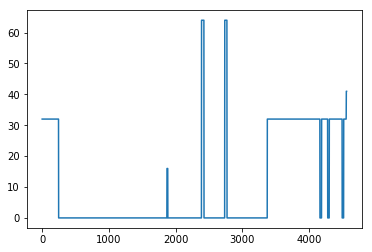

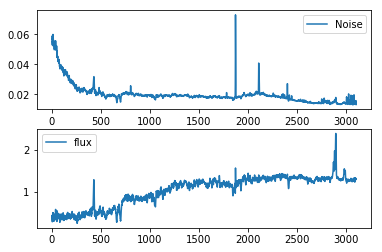

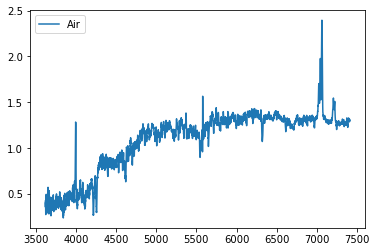

frac 1.00023028502 3622.42998417 3621.59598486
<class 'numpy.ndarray'>


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


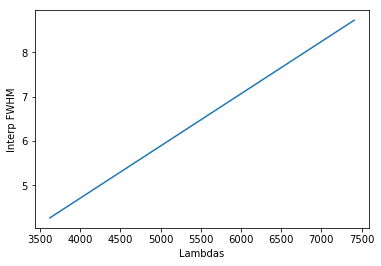

velscale 69.0297644781


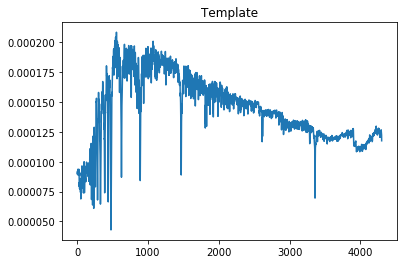

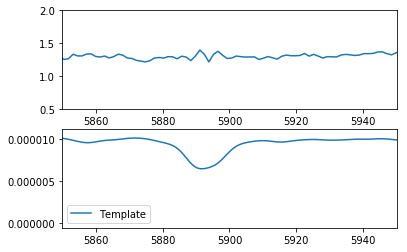

must improve chi2 by:  72.6223106215
input vel 21648.163
Best Fit:       Vel     sigma
 comp. 0:     20999       118
chi2/DOF: 2.332
Function evaluations: 23 Status: 1
Nonzero Templates:  6  /  156
Formal errors:
     dV    dsigma   dh3      dh4
       3     5.1
Elapsed time in PPXF: 5.66 s


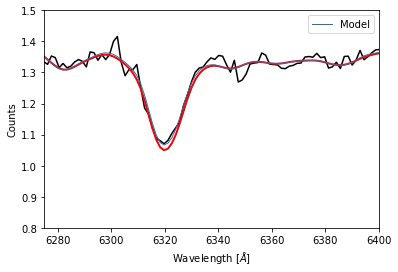

In [145]:
y=ppxf_miles(xs,ys,noise,mask,1,'yes',0,'yes',8,-1,0,0,0, logcube[0].header['SCINPVEL'],  logcube[0].header['SCINPSIG'], 2)

In [143]:
def ppxf_miles(t,flux,noise,mask,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1

    if plot=='yes':
        plt.plot(mask)
        plt.show()
        
        
        
    '''step 1: Mask with the Manga Mask'''
    #flux = ma.masked_array(flux, mask=mask)
    #t = ma.masked_array(t, mask=mask)
    #noise = ma.masked_array(noise, mask=mask)
    #print('wavelengths 1', t)
    #plt.plot(t, flux)
    #plt.show()
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540) #&
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var = 1/np.sqrt(noise)
    var_scaled=var#/np.median(flux)
    
    if plot=='yes':
        fig=plt.figure()
        ax1=fig.add_subplot(2,1,1)
        ax1.plot(var, label='Noise')
        plt.legend()
        ax2=fig.add_subplot(2,1,2)
        ax2.plot(flux, label='flux')
        plt.legend()
        plt.show()
    galaxy = flux#apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    


    if plot=='yes':
        plt.plot(lam_gal, galaxy, label='Air')
        
        plt.legend()
        plt.show()
    
    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[100]/lam_gal[99]    # Constant lambda fraction per pixel
    
    print('frac', frac, lam_gal[1], lam_gal[0])
    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
    #wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
    #print('wdisp',len(wdisp), 'lam_gal', len(lam_gal))
    print(type(lam_gal))
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    print('velscale', velscale)
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    #fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
 
    
    file_dir = glob.glob('../ppxf/miles_models/Mun*.fits')

    

    hdu = fits.open(file_dir[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    if plot=='yes':
        plt.plot(ssp)
        plt.title('Template')
        plt.show()
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        if conv=='yes':
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    if plot=='yes':
        fig=plt.figure()
        ax1=fig.add_subplot(211)
        ax1.plot(lam_gal, galaxy, label='Gal')
        ax1.set_xlim([5850,5950])
        ax1.set_ylim([0.5,2.0])
        ax2=fig.add_subplot(212)
        ax2.plot(lam_temp, ssp, label='Template')
        ax2.set_xlim([5850,5950])
        plt.legend()
        plt.show()
    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    print('must improve chi2 by: ', np.sqrt(2*len(goodpixels)))

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    print('input vel', vel)
    start = [vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              lam=lam_gal, clean=False)#was degree=12

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    
    plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=1, label='Model')

    plt.legend()
    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
    plt.xlim([6275,6400])
    plt.ylim([0.8,1.5])
    plt.show()
    return lam_gal, galaxy, pp.error[0], pp.chi2




In [136]:
'''checking parameters'''
file='../MaNGA_code/practice_logcube/manga-8459-3702-MAPS-SPX-GAU-MILESHC.fits'
maps=pyfits.open(file)
print(maps['STELLAR_VEL'].data[20,20])
print(maps['STELLAR_SIGMA'].data[20,20])

NSA_redshift=0.0723216

c=2.99792458e5
NSA_vel=c*np.log(1 + NSA_redshift)
print('NSA_vel',NSA_vel,'NSA plus', maps['STELLAR_VEL'].data[20,20]*(1+NSA_redshift)+NSA_vel )

code_vel=20994
code_sig=114

print('my velocity', code_vel)
print('my sigma', code_sig)


40.1480041309
172.026750694
NSA_vel 20933.3134659 NSA plus 20976.365038
my velocity 20994
my sigma 114


In [131]:
file='../drpall_test.fits'
drpall=pyfits.open(file)
#print(drpall[1].header)
#print(drpall[1].data[50][69])
#print(drpall[1].data[51]['NSA_Z'])

print(shape(drpall[1].data))
for i in range(len(drpall[1].data)):
    if str(drpall[1].data[i][0])=='8459' and drpall[1].data[i][1]=='3702':
        print('NSA redshift',drpall[1].data[i][60])

(3282,)
NSA redshift 0.0723216
